In [2]:
import numpy as np
import pandas as pd
import pickle
import os

from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.ndimage.filters import uniform_filter1d
from itertools import product

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import pandas as pd
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pickle
import os
import plotly.express as px
import base64
from scipy.interpolate import interp1d
import re
import collections
import socket
import struct
import time

/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_83491/91213013.py:11: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


## Load Data

In [3]:
# # Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# For Google Colab
TrainSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/TrainData.pickle"
TestSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/TestData.pickle"

FileSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/allData.pickle"
ScalerPath = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/PolyScaler.pickle"
ModelPath = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/Model.pickle"

In [5]:
# For Local
TrainSource = "./GeneratedData/TrainData.pickle"
TestSource = "./GeneratedData/TestData.pickle"

FileSource = "./GeneratedData4CO/allData.pickle"
ModelPath = "./GeneratedData4CO/Model.pickle"

ScalerPath = "./Model/Scaler.pickle"
AccelRNNModelPath = "./GeneratedData4CO/AccelRNNModel.pickle"
CORNNModelPath = "./GeneratedData4CO/CORNNModel.pickle"

In [6]:
FileList=[]
with open(FileSource,'rb') as f:
    FileList = pickle.load(f)

In [7]:
InputHeader = ["ApproachRateOther",
                "Rel_Pos_Magnitude",
                "SteerB",
                "A_Head_Center_Distance", "B_Head_Center_Distance",
                "Filtered_B_Head_Velocity_Total",
                "A_Turn",
                "B_Indicator",
                "Centerline_Offset_B",
                "RelativeRotation"] # Signaling ()

OutputHeader = ["AccelA", "Centerline_Offset_A"]

In [8]:
InputHeader_AB = ["ApproachRateOther", 
                  "Rel_Pos_Magnitude", 
                  "RelativeRotation"] # Signaling ()
InputHeader_A = ["A_Head_Center_Distance", 
                 "A_Turn"]
InputHeader_B = ["SteerB", 
                 "B_Head_Center_Distance",
                 "Filtered_B_Head_Velocity_Total",
                 "B_Indicator",
                 "Centerline_Offset_B"]

OutputHeader_A = ["AccelA", "Centerline_Offset_A"]
OutputHeader_B = ["AccelB", "Centerline_Offset_B"]

## Polynomial Model

### Training Data Preparation

In [9]:
# Concatenate all data
all_data = []
for file_path in FileList:
    if not os.path.exists(file_path):
        print(f"Could not find {file_path}")
        continue
    data = pd.read_feather(file_path)
    all_data.append(data)
all_data = pd.concat(all_data, ignore_index=True)

In [10]:
# Standardize the features
scaler=None
if os.path.exists(ScalerPath):
  with open(ScalerPath, 'rb') as file:
    scaler = pickle.load(file)
else:
  scaler = StandardScaler(with_mean=True, with_std=True)
  # Fit the scaler
  scaler.fit(all_data)
  # Save the scaler
  with open(ScalerPath, 'wb') as file:
    pickle.dump(scaler, file)

In [11]:
# Split data into training and testing sets
train_files, test_files = train_test_split(FileList, test_size=0.2, random_state=42)

# Load train and test data
train_data = pd.concat([pd.read_feather(file) for file in train_files], ignore_index=True)
test_data = pd.concat([pd.read_feather(file) for file in test_files], ignore_index=True)

### AccelA Prediction

In [12]:
# Function to create lagged features
def create_lagged_features(y, x, max_lag):
    # Concatenate y and x
    df = pd.concat([y, x], axis=1)
    target_col = y.columns[0]

    # Create lagged features for y
    for lag in range(1, max_lag + 1):
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)

    # Separate the feature data frame with lagged features
    x_lagged = df.drop(columns=[target_col]).dropna()
    
    return x_lagged

In [13]:
# Function to train and evaluate the Polynomial Regression model
def train_poly_regression(train_data, feature_list, target_col, degree, max_lag):
    y_train = train_data.loc[max_lag:,[target_col]]
    X_train = train_data[feature_list]
    X_train_scaled = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
    
    # Create lagged features
    X_train_lagged = create_lagged_features(train_data[[target_col]], X_train_scaled, max_lag)
    
    # Polynomial features
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_lagged)
    
    print(X_train_poly.shape, y_train.shape)
    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly) 
 
    # Evaluate the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    
    return model, poly, y_train_pred, y_train, train_mse

In [14]:
# Function to test and evaluate the Polynomial Regression model
def test_poly_regression(test_data, feature_list, target_col, model, poly, scaler, max_lag):
    y_test = test_data.loc[max_lag:,[target_col]]
    X_test = test_data[feature_list]
    X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)
    
    # Create lagged features
    X_test_lagged = create_lagged_features(test_data[[target_col]], X_test_scaled, max_lag)
    
    # Polynomial features
    X_test_poly = poly.transform(X_test_lagged)    
    
    # Make predictions
    y_test_pred = model.predict(X_test_poly)

    # Evaluate the model
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    return y_test_pred, y_test, test_mse

In [15]:
# def test_rolling_poly_regression(test_data, feature_list, target_col, model, poly, scaler, max_lag):
# Initial setup for rolling prediction
predictions = []
actuals = []

X_test = test_data[InputHeader]
X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

max_lag = 13
target_col = OutputHeader[0]

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [268]:
for index in range(max_lag, len(test_data)):
    # Extract the actual value for comparison
    actual_value = test_data.iloc[index][target_col]
    
    if index <= max_lag*2:
        # At the first step, use the actual values to create the lagged features
        lagged_features = create_lagged_features(test_data[[target_col]].iloc[:index], 
                                                    X_test_scaled.iloc[:index], max_lag)
    else:
        # In subsequent steps, use the predicted values
        lagged_features = create_lagged_features(pd.DataFrame(predictions[-max_lag:], columns=[target_col]), 
                                                    X_test_scaled.iloc[index-max_lag:index], max_lag)

    if not lagged_features.empty:
        X_test_poly = a_poly.transform(lagged_features.iloc[[-1]])
        
        # Predict using the model
        y_pred_scaled = a_model.predict(X_test_poly).flatten()
        print(y_pred_scaled)
        
        # # Inverse transform the predicted value
        # full_pred_array = np.zeros((1, scaler.scale_.shape[0]))  
        # idx = test_data.columns.get_loc(target_col)
        # full_pred_array[0, idx] = y_pred_scaled
        
        # y_pred = scaler.inverse_transform(full_pred_array)[0, idx]
        
        # Store the prediction and actual value
        predictions.append(y_pred_scaled)
        actuals.append(actual_value)

# Calculate Mean Squared Error between actual and predicted values
mse = mean_squared_error(actuals, predictions)

# return predictions, actuals, mse


[0.23792045]
[0.17434701]
[0.13181343]
[0.09959486]
[0.07405674]
[0.05591032]
[0.04344294]
[0.03354791]
[0.02581554]
[0.02166414]
[0.01995847]
[0.01883377]
[0.01762553]
[0.03814051]
[0.06066538]
[0.08413432]
[0.10756325]
[0.13018576]
[0.15187122]
[0.1723776]
[0.19149858]
[0.20926868]
[0.22556551]
[0.24050731]
[0.25411945]
[0.266184]
[0.27668086]
[0.28558674]
[0.29295705]
[0.29878703]
[0.30320971]
[0.30624522]
[0.30804155]
[0.30865695]
[0.30820513]
[0.30680921]
[0.30450312]
[0.30142798]
[0.29760498]
[0.29130758]
[0.28391965]
[0.2756396]
[0.26680586]
[0.2575418]
[0.24808308]
[0.23862873]
[0.22925502]
[0.22010487]
[0.21118846]
[0.20252575]
[0.19411488]
[0.18588442]
[0.17790285]
[0.17017308]
[0.16265585]
[0.15537201]
[0.14831274]
[0.1414515]
[0.13486324]
[0.12861763]
[0.12267234]
[0.11702982]
[0.11169068]
[0.10657728]
[0.10164437]
[0.09685932]
[0.09217278]
[0.08749753]
[0.08279113]
[0.07801417]
[0.07314401]
[0.06817414]
[0.06307407]
[0.05780573]
[0.052345]
[0.04665856]
[0.04069784]
[0.0344

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_polynomial.py:554: RuntimeWarning: overflow encountered in multiply
  np.multiply(


ValueError: Input X contains infinity or a value too large for dtype('float64').

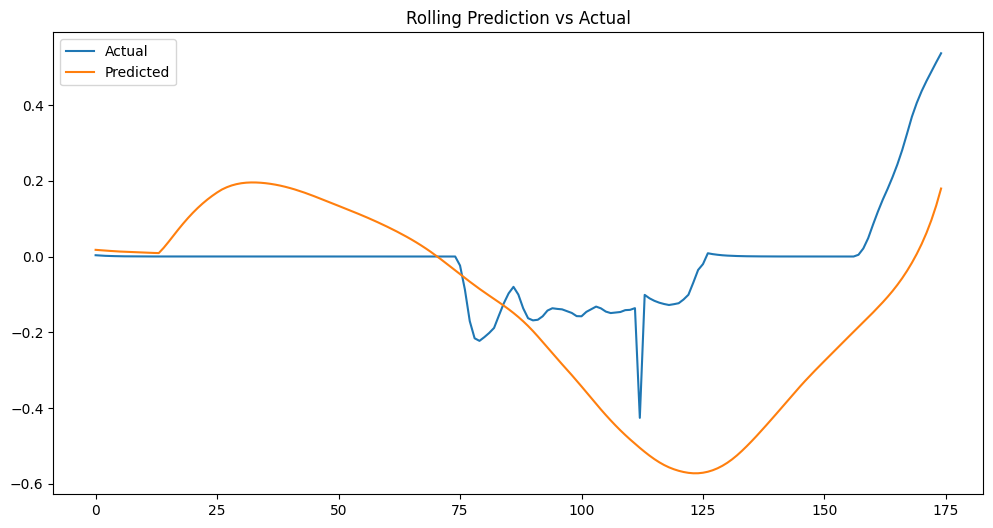

In [269]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actuals[:175], label='Actual')
plt.plot(predictions[:175], label='Predicted')
plt.title('Rolling Prediction vs Actual')
plt.legend()
plt.show()

In [16]:
def test_rolling_poly_regression(test_data, feature_list, target_col, model, poly, scaler, max_lag):
    # Initial setup for rolling prediction
    predictions = []
    actuals = []
    
    # Scale the entire test data at once
    X_test = test_data[feature_list]
    X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)
    
    for index in range(max_lag*2, len(test_data)):
        # Extract the actual value for comparison
        actual_value = test_data.iloc[index][target_col]
        
        if index <= max_lag*3:
            # At the first step, use the actual values to create the lagged features
            lagged_features = create_lagged_features(test_data[[target_col]].iloc[:index], 
                                                     X_test_scaled.iloc[:index], max_lag)
        else:
            # In subsequent steps, use the predicted values
            lagged_features = create_lagged_features(pd.DataFrame(predictions[-max_lag:], columns=[target_col]), 
                                                     X_test_scaled.iloc[index-max_lag:index], max_lag)

        if not lagged_features.empty:
            X_test_poly = poly.transform(lagged_features.iloc[[-1]])
            
            # Predict using the model
            y_pred_scaled = model.predict(X_test_poly).flatten()
            print(y_pred_scaled)
            
            # # Inverse transform the predicted value
            # full_pred_array = np.zeros((1, scaler.scale_.shape[0]))  
            # idx = test_data.columns.get_loc(target_col)
            # full_pred_array[0, idx] = y_pred_scaled
            
            # y_pred = scaler.inverse_transform(full_pred_array)[0, idx]
            
            # Store the prediction and actual value
            predictions.append(y_pred_scaled)
            actuals.append(actual_value)

    # Calculate Mean Squared Error between actual and predicted values
    mse = mean_squared_error(actuals, predictions)
    
    return predictions, actuals, mse


In [17]:
def test_rolling_RNN_poly(file, feature_list, target_col, model, poly, net, scaler, max_lag):
    print(file)
    net.eval()
    test_data = pd.read_feather(file)
    
    d = collections.deque(maxlen=max_lag)
    
    # Initial setup for rolling prediction
    predictions = []
    actuals = []
    
    # Scale the entire test data at once
    X_test = test_data[feature_list]
    X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)
    
    for index in range(max_lag, len(test_data)):
        
        # Extract the actual value for comparison
        actual_value = test_data.iloc[index][target_col]
        
        if index <= max_lag*2:
            # At the first step, use the actual values to create the lagged features
            lagged_features = create_lagged_features(test_data[[target_col]].iloc[:index], 
                                                     X_test_scaled.iloc[:index], max_lag)
        else:
            # In subsequent steps, use the predicted values
            lagged_features = create_lagged_features(pd.DataFrame(predictions[-max_lag:], columns=[target_col]), 
                                                     X_test_scaled.iloc[index-max_lag:index], max_lag)

        if not lagged_features.empty:
            X_test_poly = poly.transform(lagged_features.iloc[[-1]])
            
            # Predict using the model
            y_pred_scaled = model.predict(X_test_poly).flatten()
            print(y_pred_scaled)
            
            # # Inverse transform the predicted value
            # full_pred_array = np.zeros((1, scaler.scale_.shape[0]))  
            # idx = test_data.columns.get_loc(target_col)
            # full_pred_array[0, idx] = y_pred_scaled
            
            # y_pred = scaler.inverse_transform(full_pred_array)[0, idx]
            
            # Store the prediction and actual value
            predictions.append(y_pred_scaled)
            actuals.append(actual_value)

    # Calculate Mean Squared Error between actual and predicted values
    mse = mean_squared_error(actuals, predictions)
    
    return predictions, actuals, mse


In [246]:
predictions, actuals, mse = test_rolling_poly_regression(test_data, InputHeader, OutputHeader[0], a_model, a_poly, scaler, a_max_lag)
print(f"Rolling Test MSE: {mse}")

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.71412952]
[0.63515708]
[0.48954136]
[0.33497618]
[0.23508254]
[0.17094465]
[0.14397783]
[0.13318292]
[0.1352366]
[0.14449026]
[0.15781809]
[0.17271138]
[0.18798646]
[0.20282188]
[0.21673302]
[0.2294682]
[0.24084862]
[0.25084324]
[0.25938494]
[0.26652691]
[0.27229258]
[0.27676002]
[0.28001029]
[0.28210604]
[0.28316151]
[0.28321054]
[0.28240383]
[0.28078445]
[0.27849727]
[0.27559788]
[0.27218687]
[0.26836323]
[0.26414515]
[0.25964245]
[0.25485172]
[0.24782863]
[0.2400936]
[0.23185499]
[0.2234133]
[0.21482893]
[0.20635023]
[0.19816506]
[0.19035322]
[0.18302126]
[0.17613268]
[0.16966518]
[0.16359452]
[0.15781529]
[0.15232884]
[0.14709067]
[0.14201964]
[0.13710486]
[0.13231376]
[0.12759694]
[0.1230149]
[0.11862836]
[0.11438879]
[0.11030047]
[0.10637594]
[0.10254141]
[0.09875828]
[0.09500258]
[0.09123401]
[0.08736463]
[0.08335733]
[0.07918102]
[0.07482176]
[0.07027359]
[0.06551266]
[0.06051357]
[0.05526691]
[0.04975576]
[0.04394736]
[0.03781031]
[0.03130211]
[0.02438504]
[0.01704798]
[0.0

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_polynomial.py:554: RuntimeWarning: overflow encountered in multiply
  np.multiply(


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [44]:
# Train and evaluate the Polynomial Regression model
a_degree = 2
a_max_lag = 15
 
a_model, a_poly, a_y_train_pred, a_y_train, a_train_mse = train_poly_regression(train_data, InputHeader, OutputHeader[0], a_degree, a_max_lag)


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(140124, 351) (140124, 1)


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Train MSE: 0.002520912156189518
Test MSE: 0.002452490948268028


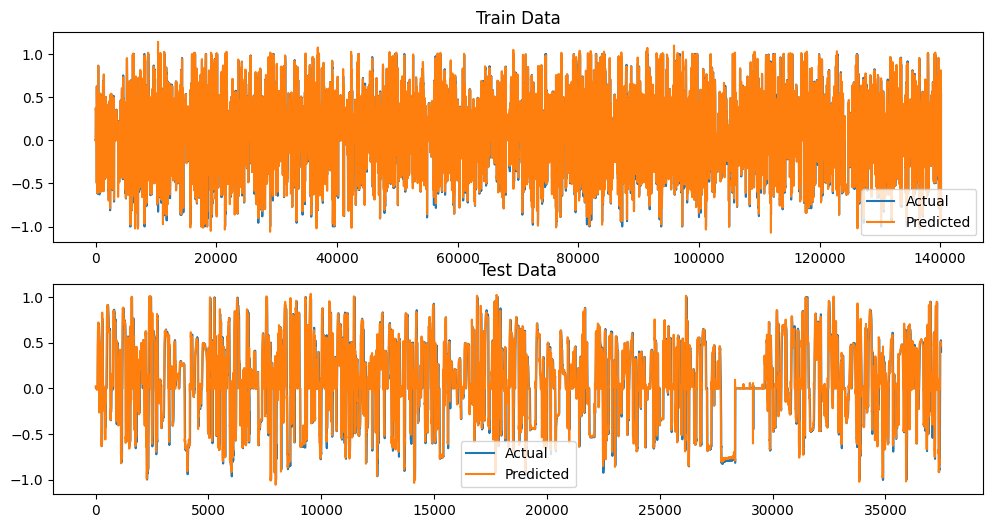

In [48]:
a_y_test_pred, a_y_test, a_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[0], a_model, a_poly, scaler, a_max_lag)

print(f"Train MSE: {a_train_mse}")
print(f"Test MSE: {a_test_mse}")

# Plot the results
plt.figure(figsize=(12, 6)) 
plt.subplot(2, 1, 1)
plt.plot(a_y_train, label='Actual')
plt.plot(a_y_train_pred, label='Predicted')
plt.title('Train Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(a_y_test, label='Actual')
plt.plot(a_y_test_pred, label='Predicted')
plt.title('Test Data')
plt.legend()

plt.show()

## RNN

In [49]:
def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length), :]
        y = targets.iloc[i + seq_length].values[0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Load and preprocess data from each file
def preprocess_data(files, seq_length):
    all_sequences = np.empty((0,seq_length,len(InputHeader)))
    all_targets = np.empty(0)

    for file_path in files:
        data = pd.read_feather(file_path)
        features = data[InputHeader]
        targets = data[[OutputHeader[0]]]
        scaled_features = scaler.transform(features)
        sequences, targetsVector = create_sequences(scaled_features,targets, seq_length)
        if(sequences.shape[0]==0):
          print("Skipping:", all_sequences.shape,sequences.shape)
          continue
        all_sequences = np.concatenate((all_sequences, sequences), axis=0)
        all_targets =  np.concatenate((all_targets, targetsVector), axis=0)

    return all_sequences,all_targets

In [50]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_length, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        # GRU layer
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * seq_length, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Reshape output to fit the fully connected layer
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        print("Shape of output before FC:", out.shape)
        return out

In [41]:
input_size = len(InputHeader)
output_size = 1



Seq_Length = 13
hidden_size = 64
num_layers = 3

coA_net = GRUModel(input_size=input_size, 
                   hidden_size=hidden_size, 
                   seq_length=Seq_Length,
                   output_size=output_size, 
                   num_layers=num_layers)
    
coA_net.load_state_dict(torch.load(CORNNModelPath))
coA_net.eval()

GRUModel(
  (rnn): GRU(10, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=832, out_features=1, bias=True)
)

In [43]:
# Train and evaluate the Polynomial Regression model
co_degree = 2
co_max_lag = 15

co_model, co_poly, co_y_train_pred, co_y_train, co_train_mse = train_poly_regression(train_data,  InputHeader, OutputHeader[1], co_degree, co_max_lag)
co_y_test_pred, co_y_test, co_test_mse = test_poly_regression(test_data,  InputHeader, OutputHeader[1], co_model, co_poly, scaler, co_max_lag)

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(140124, 351) (140124, 1)


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [39]:
def evaluate_emsemble_model(file, net, poly, model, max_lag, target_col, alpha):
    # file = './GeneratedData4CO/CP5_NYC24.feather'
    # net = coA_net
    # net.eval()
    test_data = pd.read_feather(file)

    # max_lag = 13
    predictions = []
    actuals = []

    X_test = test_data[InputHeader]
    y_test = test_data[[target_col]]
    X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

    # sequences, targetsVector = create_sequences(X_test_scaled, targets, max_lag)
    xs = []
    actuals = []
    for i in range(len(X_test_scaled) - max_lag):
        # from 0 to 425-13
        x = X_test_scaled.values[i:(i + max_lag), :]
        y = y_test.iloc[i + max_lag].values[0] # from 13 to 425
        xs.append(x)
        actuals.append(y)
    xs = np.array(xs)
    actuals = np.array(actuals)

    # accelA_net(torch.Tensor(xs)).item()
    rnn_predictions = net(torch.Tensor(xs)).detach().numpy().squeeze()
    
    # alpha = 0.88

    for index in range(max_lag, len(test_data)):
        # from 13 to 425
        
        if index <= max_lag*2:
            # At the first step, use the actual values to create the lagged features
            lagged_features = create_lagged_features(pd.DataFrame(rnn_predictions[index-max_lag:index], columns=[target_col]),
                                                        X_test_scaled.iloc[:index], max_lag)
        else:
            # In subsequent steps, use the predicted values
            lagged_features = create_lagged_features(pd.DataFrame(predictions[-max_lag:], columns=[target_col]), 
                                                    X_test_scaled.iloc[index-max_lag:index], max_lag)

        if not lagged_features.empty:
            # print(index)
            X_test_poly = poly.transform(lagged_features.iloc[[-1]])
            # print(X_test_poly.shape)
            
            # Predict using the model
            y_pred_scaled = model.predict(X_test_poly).flatten()
            # print(y_pred_scaled)
            
            # Store the prediction and actual value
            predictions.append(alpha * y_pred_scaled + (1 - alpha) * rnn_predictions[index-max_lag])
            # print(predictions)
            # actuals.append(actual_value)
    
    return actuals, predictions, rnn_predictions

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Shape of output before FC: torch.Size([412, 1])


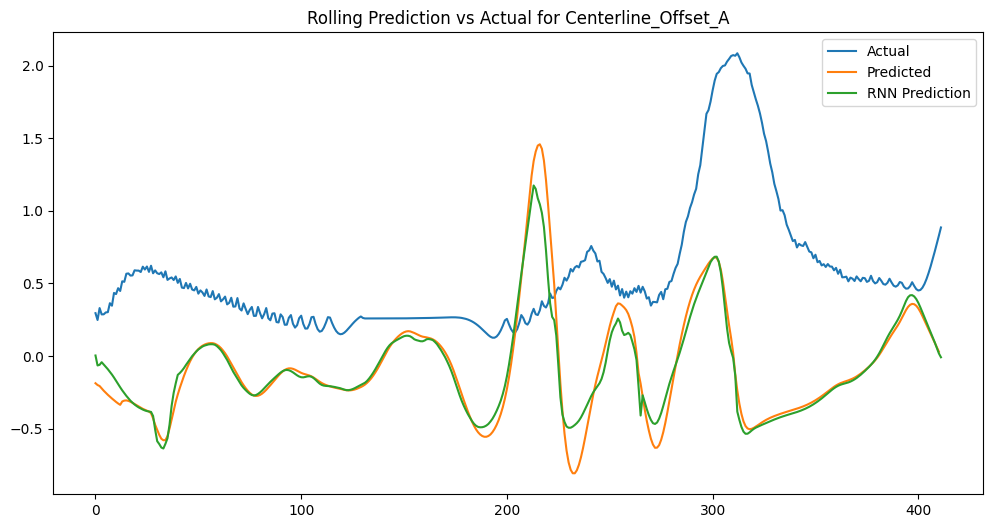

In [40]:
actuals, predictions, rnn_predictions = evaluate_emsemble_model('./GeneratedData4CO/CP5_NYC24.feather', 
                                                                coA_net, co_poly, co_model, max_lag, OutputHeader[1], alpha=0.7)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.plot(rnn_predictions, label='RNN Prediction')
plt.title('Rolling Prediction vs Actual for Centerline_Offset_A')
plt.legend()
plt.show()

In [46]:
Seq_Length = 15
hidden_size = 16
num_layers = 2

accelA_net = GRUModel(input_size=input_size, 
                      hidden_size=hidden_size, 
                      seq_length=Seq_Length,
                      output_size=output_size, 
                      num_layers=num_layers)
    
accelA_net.load_state_dict(torch.load(AccelRNNModelPath))
accelA_net.eval()

GRUModel(
  (rnn): GRU(10, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=240, out_features=1, bias=True)
)

In [47]:
actuals, predictions, rnn_predictions = evaluate_emsemble_model('./GeneratedData4CO/CP5_NYC25.feather', 
                                                                accelA_net, a_poly, a_model, max_lag, OutputHeader[0], alpha=0.85)

# Plot the results
# plt.figure(figsize=(6, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.plot(rnn_predictions, label='RNN Prediction')
plt.title('Rolling Prediction vs Actual for Accel_A')
plt.legend()
plt.show()

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (501x208 and 240x1)

In [443]:
def DrawPicture(file, net, Seq_Length):
    print(file)
    net.eval()
    data = pd.read_feather(file)
    features = data[InputHeader]
    targets = data[[OutputHeader[0]]]
    scaled_features = scaler.transform(features)
    sequences, targetsVector = create_sequences(scaled_features, targets, Seq_Length)
    # print(sequences.shape)
    out = net(torch.Tensor(sequences)).detach().numpy()
    
    
    plt.plot(targetsVector, label='original Accel', color='b')
    plt.plot(out, label='predicted Accel', color='r')
    # plt.ylim(-1,1)
    plt.legend()
    plt.show()

#### Inspect Coefficient

In [29]:
coefficients = a_model.coef_.flatten()
feature_names = a_poly.get_feature_names_out()
feature_names

array(['1', 'ApproachRateOther', 'Rel_Pos_Magnitude', 'SteerB',
       'A_Head_Center_Distance', 'B_Head_Center_Distance',
       'Filtered_B_Head_Velocity_Total', 'A_Turn', 'B_Indicator',
       'Centerline_Offset_B', 'RelativeRotation', 'AccelA_lag1',
       'AccelA_lag2', 'AccelA_lag3', 'AccelA_lag4', 'AccelA_lag5',
       'AccelA_lag6', 'AccelA_lag7', 'AccelA_lag8', 'AccelA_lag9',
       'AccelA_lag10', 'AccelA_lag11', 'AccelA_lag12', 'AccelA_lag13',
       'ApproachRateOther^2', 'ApproachRateOther Rel_Pos_Magnitude',
       'ApproachRateOther SteerB',
       'ApproachRateOther A_Head_Center_Distance',
       'ApproachRateOther B_Head_Center_Distance',
       'ApproachRateOther Filtered_B_Head_Velocity_Total',
       'ApproachRateOther A_Turn', 'ApproachRateOther B_Indicator',
       'ApproachRateOther Centerline_Offset_B',
       'ApproachRateOther RelativeRotation',
       'ApproachRateOther AccelA_lag1', 'ApproachRateOther AccelA_lag2',
       'ApproachRateOther AccelA_lag3', 'A

In [30]:
weights = pd.DataFrame(data=coefficients, index=feature_names, columns=['Coefficient'])
sorted_weights = weights.sort_values(by='Coefficient', ascending=False)

sorted_weights.iloc[:20,:]

,Coefficient
AccelA_lag1,1.329064
AccelA_lag2 AccelA_lag9,0.894231
AccelA_lag2 AccelA_lag11,0.743177
AccelA_lag1 AccelA_lag10,0.682694
AccelA_lag2 AccelA_lag3,0.575068
AccelA_lag4 AccelA_lag10,0.553722
AccelA_lag2 AccelA_lag7,0.466855
AccelA_lag1 AccelA_lag2,0.428114
AccelA_lag5 AccelA_lag8,0.408425
AccelA_lag9 AccelA_lag12,0.375233


### Centerline Offset Prediction

In [31]:
# Split data into training and testing sets
train_files, test_files = train_test_split(FileList, test_size=0.2, random_state=42)

# Load train and test data
train_data = pd.concat([pd.read_feather(file) for file in train_files], ignore_index=True)
test_data = pd.concat([pd.read_feather(file) for file in test_files], ignore_index=True)
# Train and evaluate the Polynomial Regression model
co_degree = 2
co_max_lag = 13

co_model, co_poly, co_y_train_pred, co_y_train, co_train_mse = train_poly_regression(train_data,  InputHeader, OutputHeader[1], co_degree, co_max_lag)
co_y_test_pred, co_y_test, co_test_mse = test_poly_regression(test_data,  InputHeader, OutputHeader[1], co_model, co_poly, scaler, co_max_lag)

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(140126, 300) (140126, 1)


/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Train MSE: 0.010574657990646835
Test MSE: 0.011367962314671779


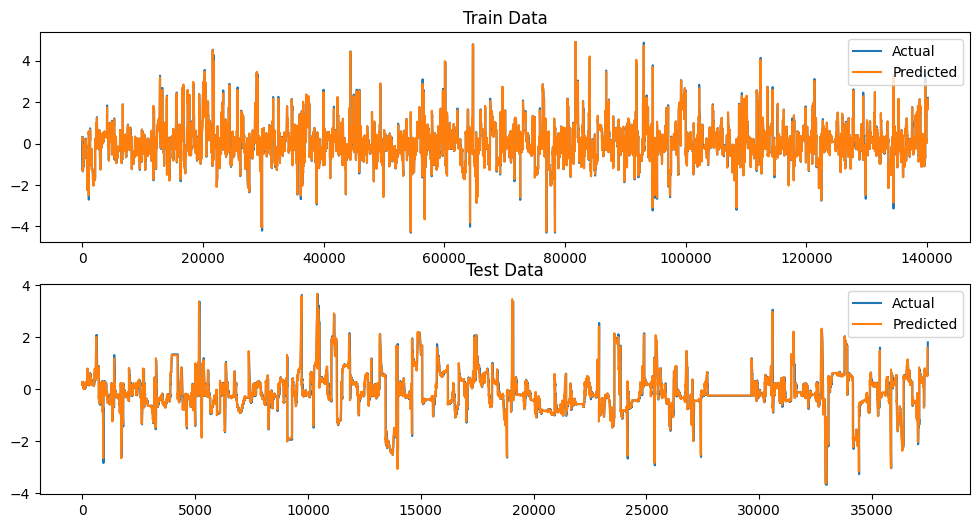

In [32]:
print(f"Train MSE: {co_train_mse}")
print(f"Test MSE: {co_test_mse}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(co_y_train, label='Actual')
plt.plot(co_y_train_pred, label='Predicted')
plt.title('Train Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(co_y_test, label='Actual')
plt.plot(co_y_test_pred, label='Predicted')
plt.title('Test Data')
plt.legend()

plt.show()

#### Inspect Coefficients

In [33]:
coefficients = co_model.coef_.flatten()
feature_names = co_poly.get_feature_names_out()

weights = pd.DataFrame(data=coefficients, index=feature_names, columns=['Coefficient'])
sorted_weights = weights.sort_values(by='Coefficient', ascending=False)

sorted_weights.iloc[:20,:]

,Coefficient
Centerline_Offset_A_lag1,0.776697
Centerline_Offset_A_lag4 Centerline_Offset_A_lag13,0.292930
Centerline_Offset_A_lag8 Centerline_Offset_A_lag9,0.251559
Centerline_Offset_A_lag2,0.243332
Centerline_Offset_A_lag3 Centerline_Offset_A_lag8,0.227383
Centerline_Offset_A_lag7 Centerline_Offset_A_lag8,0.162686
Centerline_Offset_A_lag4^2,0.145681
Centerline_Offset_A_lag6 Centerline_Offset_A_lag10,0.123475
Centerline_Offset_A_lag10 Centerline_Offset_A_lag11,0.118383
Centerline_Offset_A_lag2 Centerline_Offset_A_lag12,0.118320


### Visualization

In [202]:
# Function to test and evaluate the Polynomial Regression model with rolling prediction considering initial status
def test_rolling_poly_regression(test_data, feature_list, target_col, model, poly, scaler, max_lag):
    # Find the starting index where "A_Head_Center_Distance" > 30 for the first time
    start_index = test_data[test_data['A_Head_Center_Distance'] < 30].index.min()
    
    # Ensure there are enough previous data points to create the lagged features
    start_index = max(start_index, max_lag)
    
    predictions = []
    actuals = []
    
    for index in range(start_index, len(test_data)):
        # Isolate the portion of the test data to predict on
        input_data = test_data.iloc[index-max_lag:index+1]
        
        # Scale the input_data
        scaled_input = scaler.transform(input_data)
        input_df = pd.DataFrame(scaled_input, columns=input_data.columns)
        
        # Create lagged features from predicted data
        input_lagged = pd.DataFrame(input_df.loc[max_lag, feature_list + [target_col]]).T
        for lag in range(1, max_lag + 1):
            input_lagged[f'{target_col}_lag{lag}'] = input_df.loc[lag, target_col]
        input_lagged = input_lagged.dropna()
        
        # Prepare features for model prediction
        if not input_lagged.empty:
            X_test = input_lagged.iloc[[-1]].drop(columns=[target_col])
            X_test_poly = poly.transform(X_test)
            
            # Predict using the model
            y_pred_scaled = model.predict(X_test_poly)
            
            # Inverse transform the predicted value
            full_pred_array = np.zeros((1, scaler.scale_.shape[0]))  # Placeholder for full feature set
            idx = input_df.columns.get_loc(target_col)  # Find the index of the target column in scaled data
            full_pred_array[0, idx] = y_pred_scaled  # Assign the predicted value
            
            y_pred = scaler.inverse_transform(full_pred_array)[0, idx]  # Inverse transform to get actual scale
            
            # Store the prediction and actual value
            predictions.append(y_pred)
            actuals.append(test_data.iloc[index][target_col])

    # Calculate Mean Squared Error between actual and predicted values
    mse = mean_squared_error(actuals, predictions)
    
    return predictions, actuals, mse


In [185]:
file = './GeneratedData/CP8_NYC7.feather'
test_data = pd.read_feather(file)
max_lag = a_max_lag
feature_list = InputHeader
target_col = 'AccelA'

In [186]:
test_data

,ApproachRate,ApproachRateOther,Rel_Pos_Magnitude,ScenarioTime,AccelA,AccelB,SteerA,SteerB,A_Head_Center_Distance,B_Head_Center_Distance,Filtered_A_Head_Velocity_Total,Filtered_B_Head_Velocity_Total,A_Turn,B_Turn,Centerline_Offset_A,Centerline_Offset_B,A_Indicator,B_Indicator,RelativeRotation
0,-1.794694,0.889414,64.234198,0.0000,0.0000,0.2133,0.0143,0.2279,29.295811,34.979173,0.906838,0.896083,1,1,0.249107,1.389996,0,1,-174.4524
1,-2.694894,1.340429,64.046405,0.0420,0.0000,0.2135,0.0108,0.2279,29.200989,34.886583,1.356749,1.350079,1,1,0.249971,1.408000,0,1,-174.7355
2,-3.588182,1.791306,63.857313,0.0840,0.0000,0.2137,0.0076,0.2279,29.106068,34.792792,1.799849,1.803663,1,1,0.284618,1.428408,0,1,-175.0263
3,-4.485484,2.247128,63.670521,0.1255,0.0000,0.2124,0.0045,0.2279,29.013043,34.699396,2.242005,2.261908,1,1,0.341649,1.428096,0,1,-175.3200
4,-4.475956,2.257594,63.482930,0.1675,0.0000,0.2108,0.0010,0.2263,28.920318,34.604894,2.221847,2.271179,1,1,0.295670,1.433566,0,1,-175.6221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,0.960588,-0.960588,53.691836,30.7368,-0.5859,-0.2393,0.0192,-0.0268,18.921954,34.861983,0.000000,0.961132,1,1,1.028805,3.077781,0,0,-182.4561
735,0.856795,-0.856795,53.727829,30.7788,-0.5859,-0.2411,0.0192,-0.0268,18.921954,34.897988,0.000000,0.857274,1,1,1.028805,3.110690,0,0,-182.4404
736,0.758351,-0.758351,53.759522,30.8203,-0.5859,-0.2424,0.0192,-0.0268,18.921954,34.929692,0.000000,0.758762,1,1,1.028805,3.139744,0,0,-182.4265
737,0.566953,-0.566953,53.786917,30.8623,-0.5859,-0.2434,0.0192,-0.0268,18.921954,34.957096,0.000000,0.567260,1,1,1.028805,3.164882,0,0,-182.4145


In [187]:
start_index = test_data[test_data['A_Head_Center_Distance'] < 20].index.min()

In [188]:
start_index

105

In [189]:
predictions = []
actuals = []

In [190]:
scaler.scale_.shape

(19,)

In [191]:
len(test_data)

739

In [192]:
# for index in range(start_index, len(test_data)):
index = start_index
input_data = test_data.iloc[index-a_max_lag:index+1]
scaled_input = scaler.transform(input_data)
input_df = pd.DataFrame(scaled_input, columns=input_data.columns)

In [193]:
input_df

,ApproachRate,ApproachRateOther,Rel_Pos_Magnitude,ScenarioTime,AccelA,AccelB,SteerA,SteerB,A_Head_Center_Distance,B_Head_Center_Distance,Filtered_A_Head_Velocity_Total,Filtered_B_Head_Velocity_Total,A_Turn,B_Turn,Centerline_Offset_A,Centerline_Offset_B,A_Indicator,B_Indicator,RelativeRotation
0,-0.902198,0.497415,1.629731,-0.677753,0.041200,0.399285,-0.003663,0.288395,0.467633,1.187843,0.220937,-0.408538,1.483567,1.801927,-0.227681,-0.098988,1.854951,0.132858,-1.044958
1,-0.905936,0.504442,1.615495,-0.674213,0.035707,0.404678,-0.003663,0.281537,0.454336,1.180519,0.219845,-0.399967,1.483567,1.801927,-0.223112,-0.098034,1.854951,0.132858,-1.045358
2,-0.906682,0.509733,1.601194,-0.670631,0.032602,0.408664,-0.003663,0.272393,0.441029,1.173110,0.214622,-0.393514,1.483567,1.801927,-0.229163,-0.096344,1.854951,0.132858,-1.045756
3,-0.907597,0.515302,1.586878,-0.667091,0.024005,0.411478,-0.003663,0.260962,0.427776,1.165628,0.209403,-0.386722,1.483567,1.801927,-0.230327,-0.099757,1.854951,0.132858,-1.046151
4,-0.908354,0.520625,1.572562,-0.663509,0.007289,0.413589,-0.003663,0.247245,0.414586,1.158084,0.204169,-0.380229,1.483567,1.801927,-0.226472,-0.102323,1.854951,0.132858,-1.046538
5,-0.910187,0.526869,1.558159,-0.659926,-0.047637,0.414996,-0.003663,0.233529,0.401375,1.150435,0.200032,-0.372608,1.483567,1.801927,-0.227955,-0.104010,1.854951,0.132858,-1.046919


In [194]:
input_lagged = pd.DataFrame(input_df.loc[max_lag, feature_list + [target_col]]).T

In [195]:
input_lagged

,ApproachRateOther,Rel_Pos_Magnitude,SteerB,A_Head_Center_Distance,B_Head_Center_Distance,Filtered_B_Head_Velocity_Total,A_Turn,B_Indicator,Centerline_Offset_B,RelativeRotation,AccelA
5,0.526869,1.558159,0.233529,0.401375,1.150435,-0.372608,1.483567,0.132858,-0.10401,-1.046919,-0.047637


In [196]:
for lag in range(1, max_lag + 1):
    input_lagged[f'{target_col}_lag{lag}'] = input_df.loc[lag, target_col]
input_lagged = input_lagged.dropna()

In [197]:
input_lagged

,ApproachRateOther,Rel_Pos_Magnitude,SteerB,A_Head_Center_Distance,B_Head_Center_Distance,Filtered_B_Head_Velocity_Total,A_Turn,B_Indicator,Centerline_Offset_B,RelativeRotation,AccelA,AccelA_lag1,AccelA_lag2,AccelA_lag3,AccelA_lag4,AccelA_lag5
5,0.526869,1.558159,0.233529,0.401375,1.150435,-0.372608,1.483567,0.132858,-0.10401,-1.046919,-0.047637,0.035707,0.032602,0.024005,0.007289,-0.047637


In [198]:
# Prepare features for model prediction
if not input_lagged.empty:
    X_test = input_lagged.iloc[[-1]].drop(columns=[target_col])
    X_test_poly = a_poly.transform(X_test)

# Predict using the model
y_pred_scaled = a_model.predict(X_test_poly)

# Inverse transform the predicted value
full_pred_array = np.zeros((1, scaler.scale_.shape[0]))  # Placeholder for full feature set
idx = input_df.columns.get_loc(target_col)  # Find the index of the target column in scaled data
full_pred_array[0, idx] = y_pred_scaled  # Assign the predicted value

y_pred = scaler.inverse_transform(full_pred_array)[0, idx]  # Inverse transform to get actual scale

# Store the prediction and actual value
predictions.append(y_pred)
actuals.append(test_data.iloc[index][target_col])

# Calculate Mean Squared Error between actual and predicted values
mse = mean_squared_error(actuals, predictions)

# return predictions, actuals, mse


In [205]:
def DrawPicture(file, a_model, a_poly, a_max_lag):
    test_data = pd.read_feather(file)
    plt.figure(figsize=(14, 6))
    
    # For AccelA
    # a_y_test_pred, a_y_test, a_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[0], a_model, a_poly, scaler, a_max_lag)

    # Example usage:
    predictions, actuals, test_mse = test_rolling_poly_regression(
        test_data,  # DataFrame containing the test data
        InputHeader,  # List of input features
        'AccelA',  # Target column
        a_model,  # Trained LinearRegression model
        a_poly,  # PolynomialFeatures instance
        scaler,  # Trained scaler
        a_max_lag  # Max lag
    )

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label='Actual Values')
    plt.plot(predictions, label='Predicted Values')
    plt.title('Rolling Prediction Results')
    plt.xlabel('Time Steps')
    plt.ylabel('AccelA')
    plt.legend()
    plt.show()

<Figure size 1400x600 with 0 Axes>

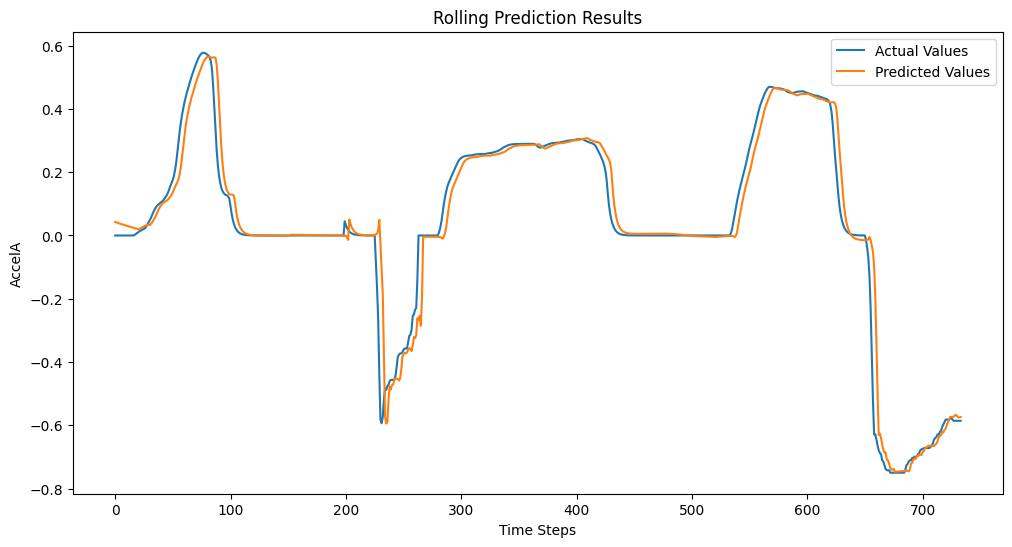

In [206]:
# Example
DrawPicture('./GeneratedData/CP8_NYC7.feather', a_model, a_poly, a_max_lag)

In [63]:
def DrawPicture(file, a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag):
    test_data = pd.read_feather(file)
    plt.figure(figsize=(14, 6))
    
    # For AccelA
    a_y_test_pred, a_y_test, a_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[0], a_model, a_poly, scaler, a_max_lag)
    
    # For Centerline_Offset_A
    co_y_test_pred, co_y_test, co_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[1], co_model, co_poly, scaler, co_max_lag)

    plt.subplot(1, 2, 1)
    plt.plot(a_y_test, label='Original AccelA', color='b')
    plt.plot(pd.DataFrame(a_y_test_pred).shift(a_max_lag), label='Predicted AccelA', color='r')
    plt.xlabel('Scenario Time')
    plt.ylabel('AccelA')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(co_y_test, label='Original Centerline Offset', color='b')
    plt.plot(pd.DataFrame(co_y_test_pred).shift(co_max_lag), label='Predicted Centerline Offset', color='r')
    plt.xlabel('Scenario Time')
    plt.ylabel('Centerline Offset A')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print(file)
    print(f"AccelA Test MSE: {a_test_mse}")
    print(f"Centerline_Offset_A Test MSE: {co_test_mse}")

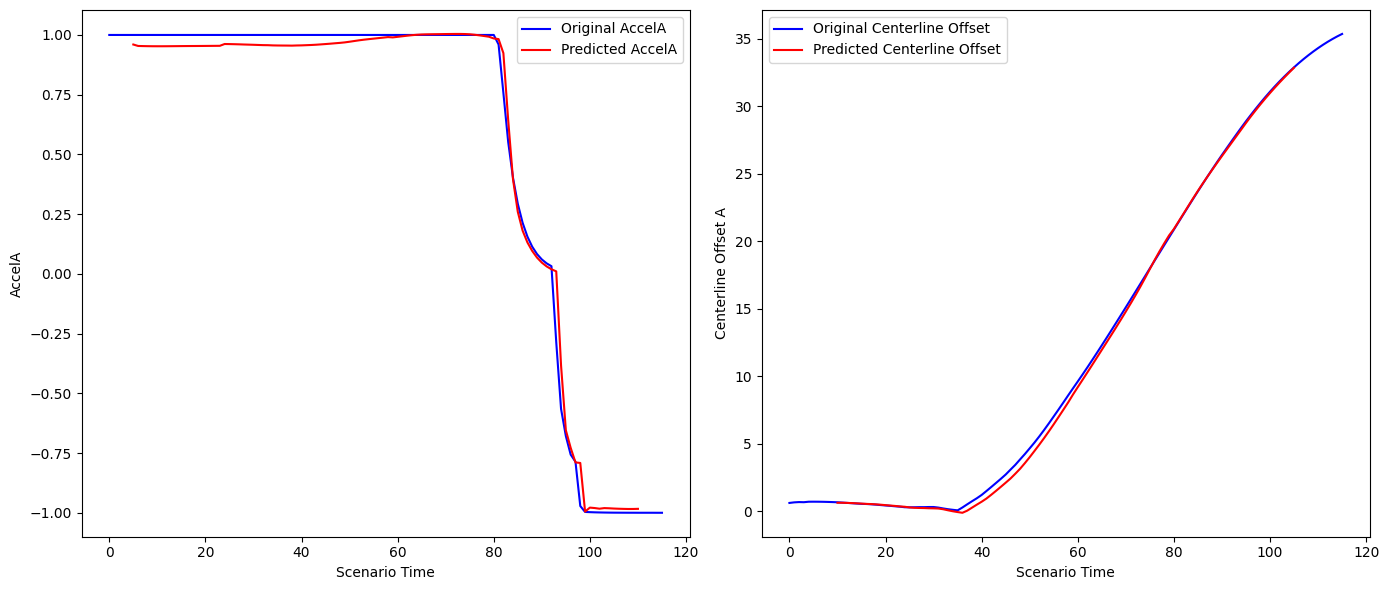

./GeneratedData/CP5_NYC36.feather
AccelA Test MSE: 0.014782375993177423
Centerline_Offset_A Test MSE: 0.0025828630653893106


In [64]:
# Example
DrawPicture('./GeneratedData/CP5_NYC36.feather', a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)

In [65]:
OutDict = {}

for file in test_files:
    test_data = pd.read_feather(file)
    
    # Test and evaluate the model on the test set
    a_y_test_pred, a_y_test, a_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[0], a_model, a_poly, scaler, a_max_lag)
    
    co_y_test_pred, co_y_test, co_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[1], co_model, co_poly, scaler, co_max_lag)

    # Store the test MSE for each file
    OutDict[file] = [a_test_mse, co_test_mse]

In [66]:
OutDict = dict(sorted(OutDict.items(), key=lambda item: item[1], reverse=True))
# OutDict

----- WORST-----


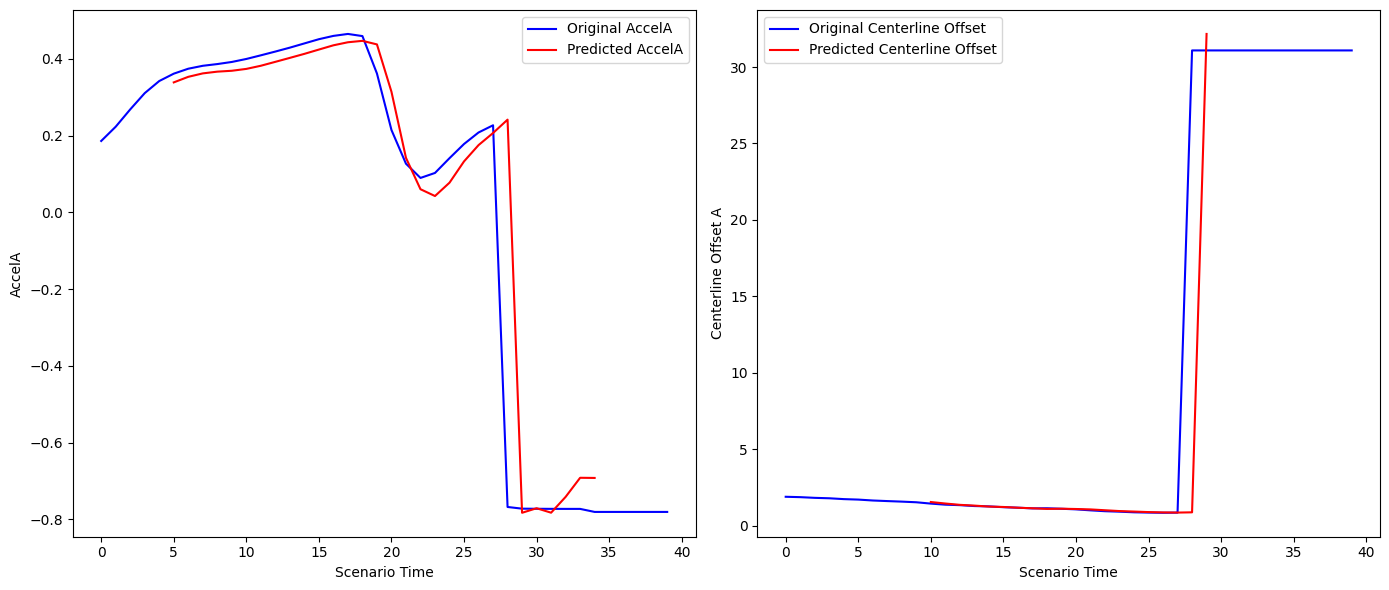

./GeneratedData/CP8_NYC1.feather
AccelA Test MSE: 0.17954738952605773
Centerline_Offset_A Test MSE: 0.85594618066099


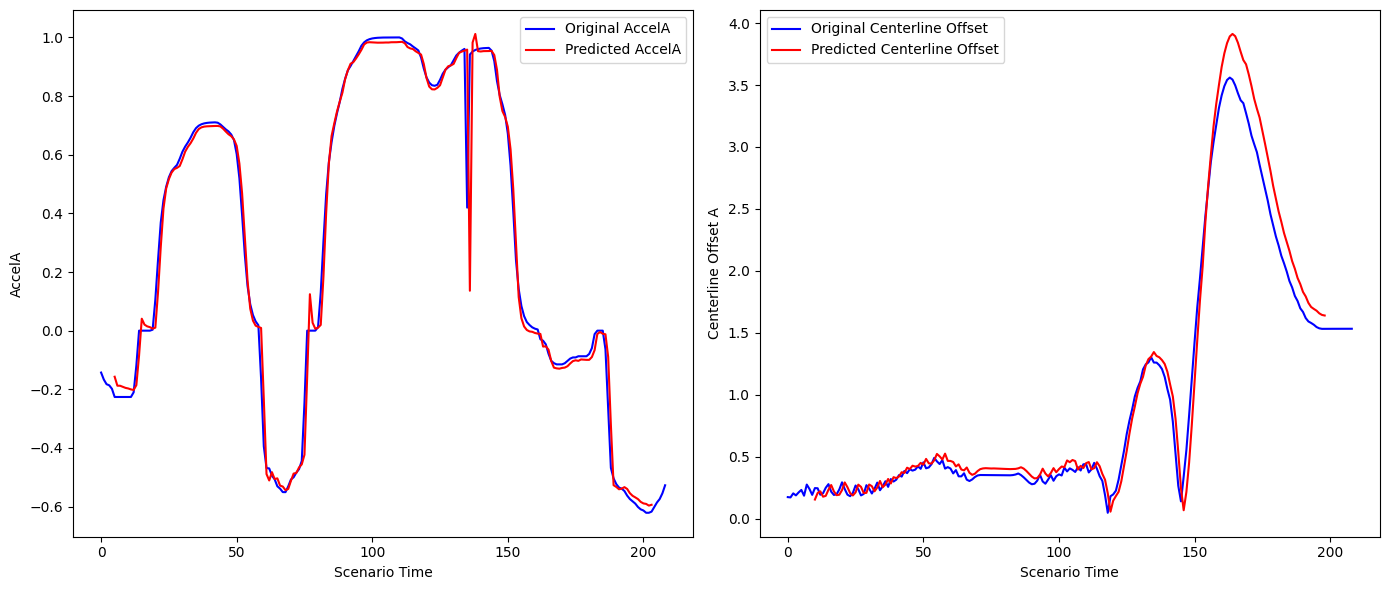

./GeneratedData/CP8_ISR31.feather
AccelA Test MSE: 0.03571813254676107
Centerline_Offset_A Test MSE: 0.00068734981203876


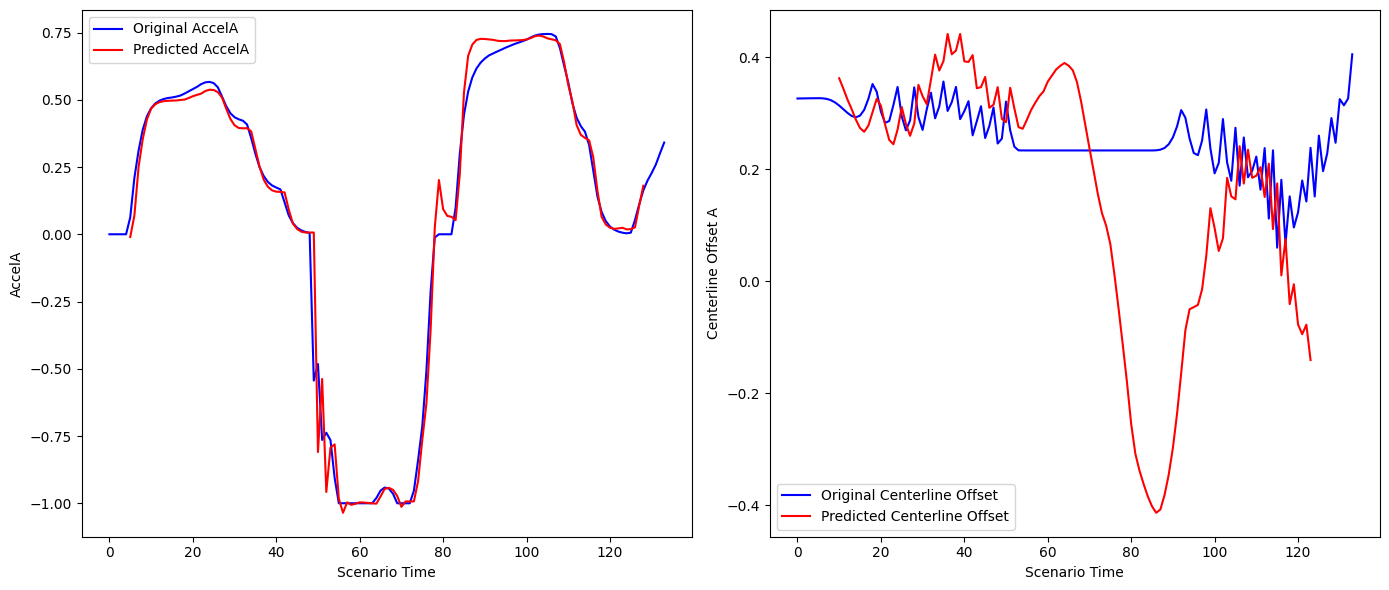

./GeneratedData/CP8_ISR13.feather
AccelA Test MSE: 0.03434618816833624
Centerline_Offset_A Test MSE: 0.0016153972961037118


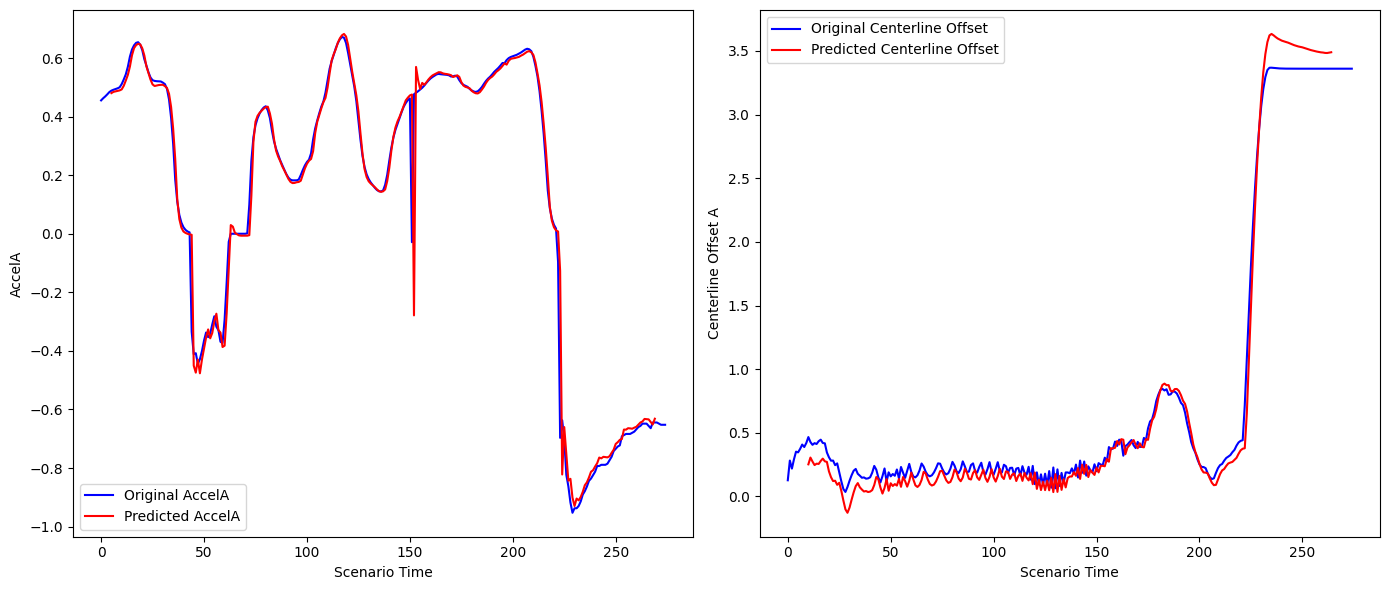

./GeneratedData/CP6_ISR38.feather
AccelA Test MSE: 0.03065849574136992
Centerline_Offset_A Test MSE: 0.0003760848625535464


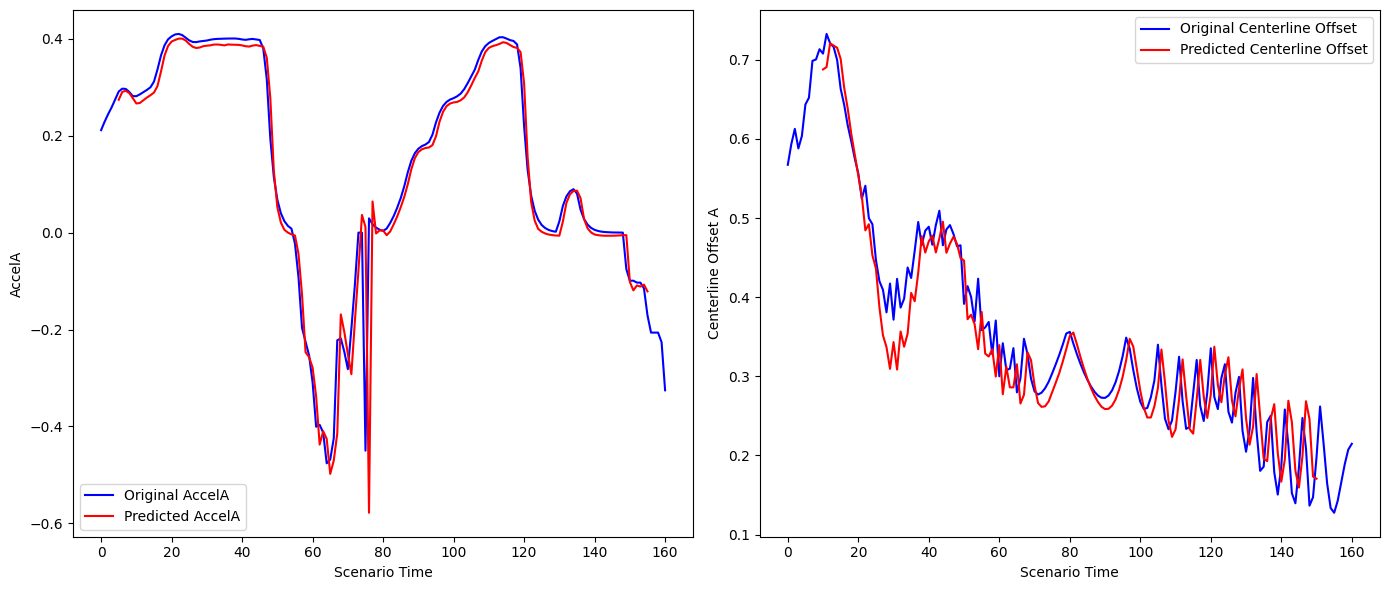

./GeneratedData/CP7_ISR30.feather
AccelA Test MSE: 0.02662558339913489
Centerline_Offset_A Test MSE: 4.747280738795933e-05
----- BEST-----


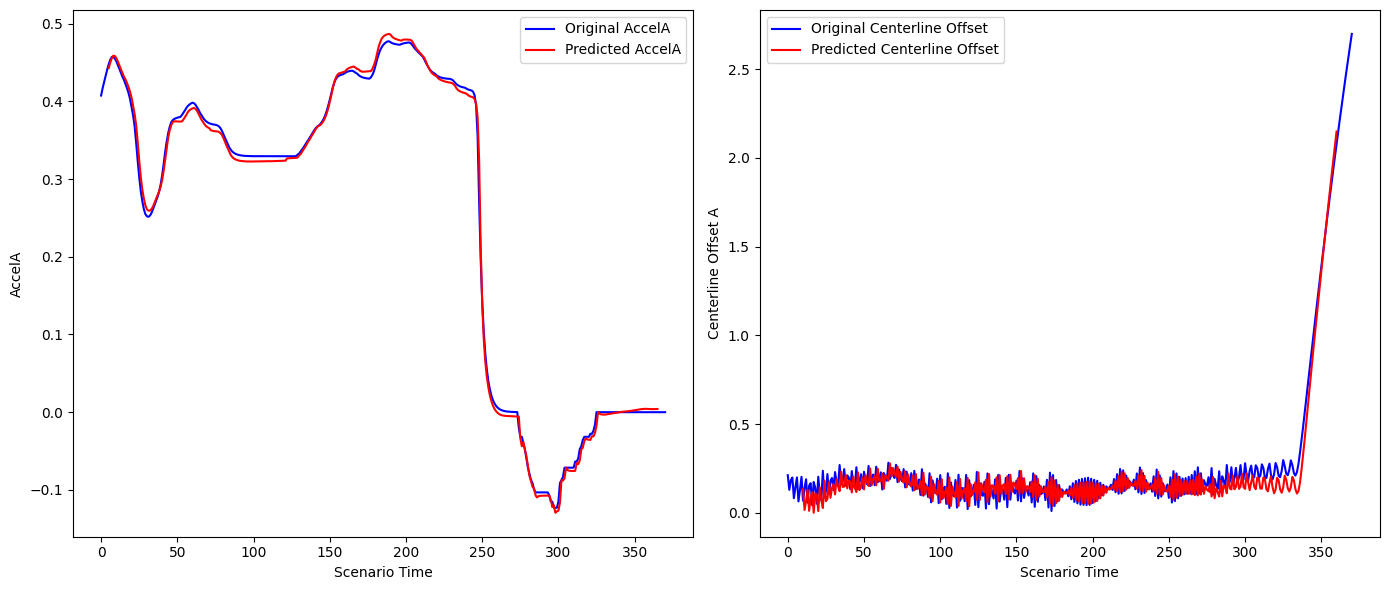

./GeneratedData/CP7_NYC25.feather
AccelA Test MSE: 0.00029414187826905214
Centerline_Offset_A Test MSE: 0.0002599970023406234


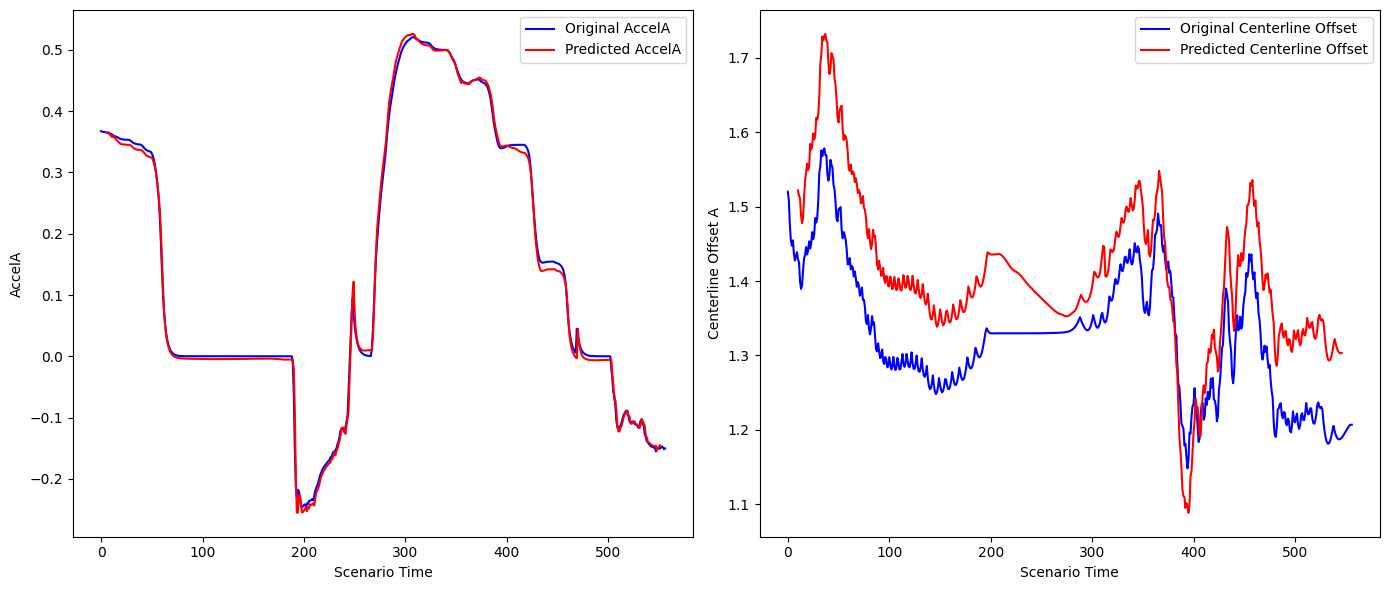

./GeneratedData/CP5_NYC6PARENT.feather
AccelA Test MSE: 0.0004620354505096723
Centerline_Offset_A Test MSE: 0.00024437389961473794


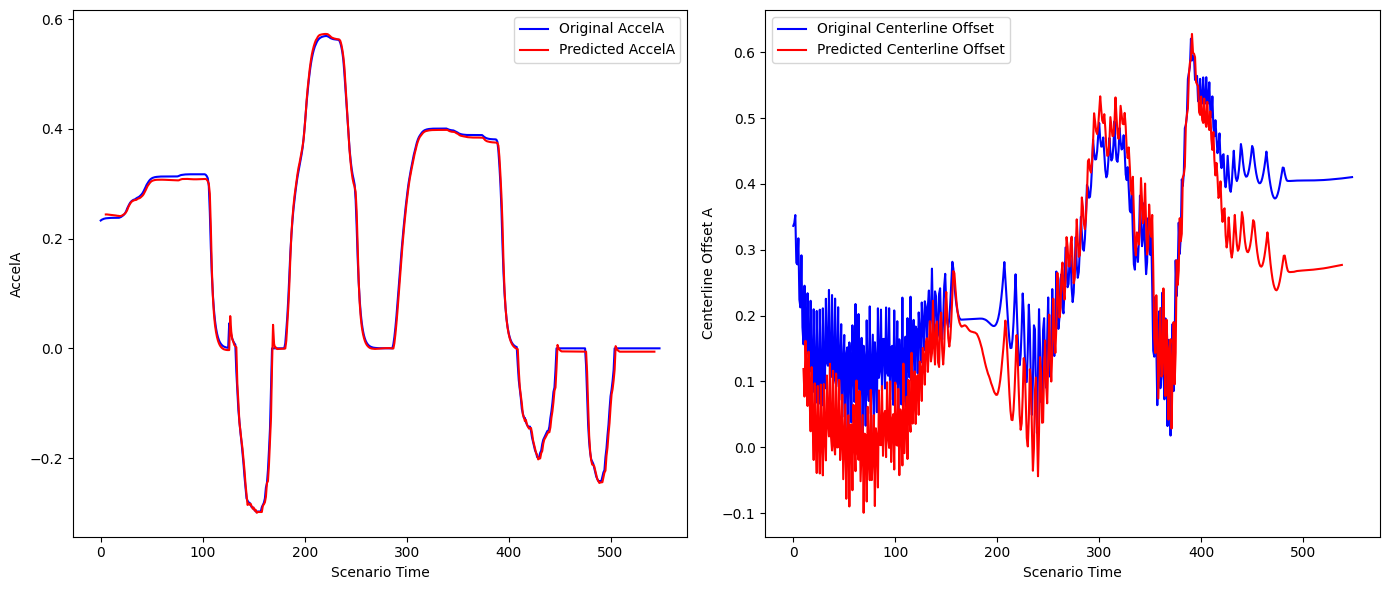

./GeneratedData/CP6_NYC16.feather
AccelA Test MSE: 0.0005047177433218962
Centerline_Offset_A Test MSE: 0.00029255767364244183


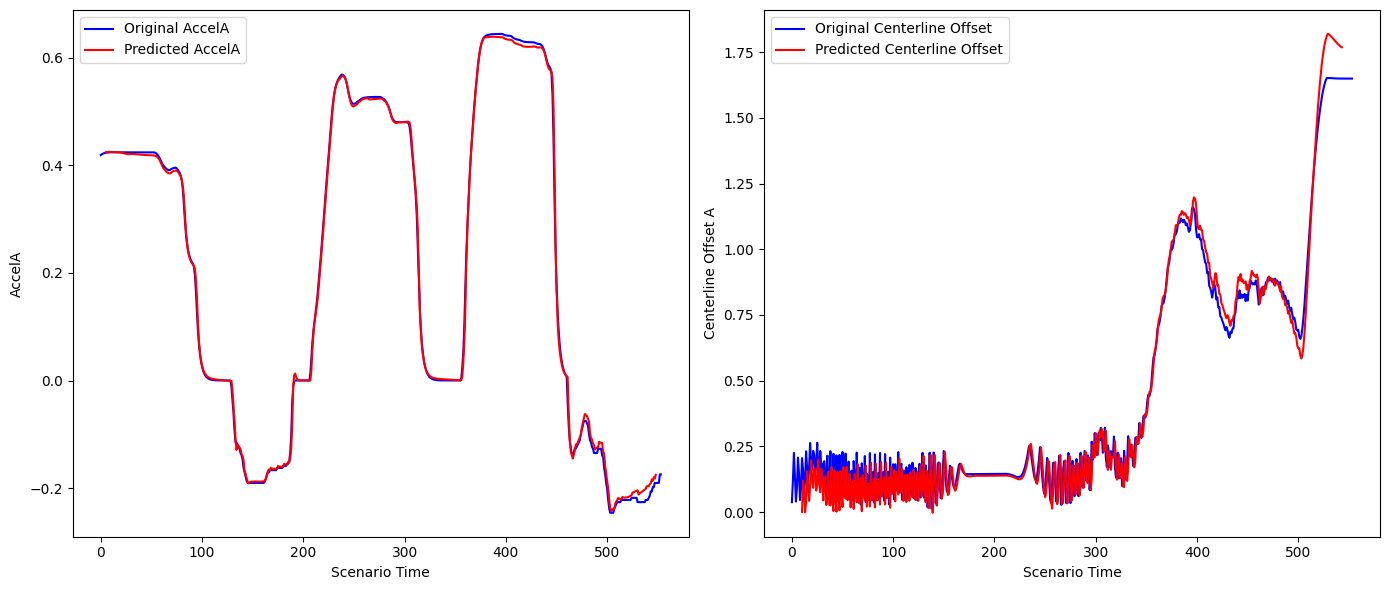

./GeneratedData/CP3_NYC16.feather
AccelA Test MSE: 0.0005183412095007085
Centerline_Offset_A Test MSE: 0.0001635662711268551


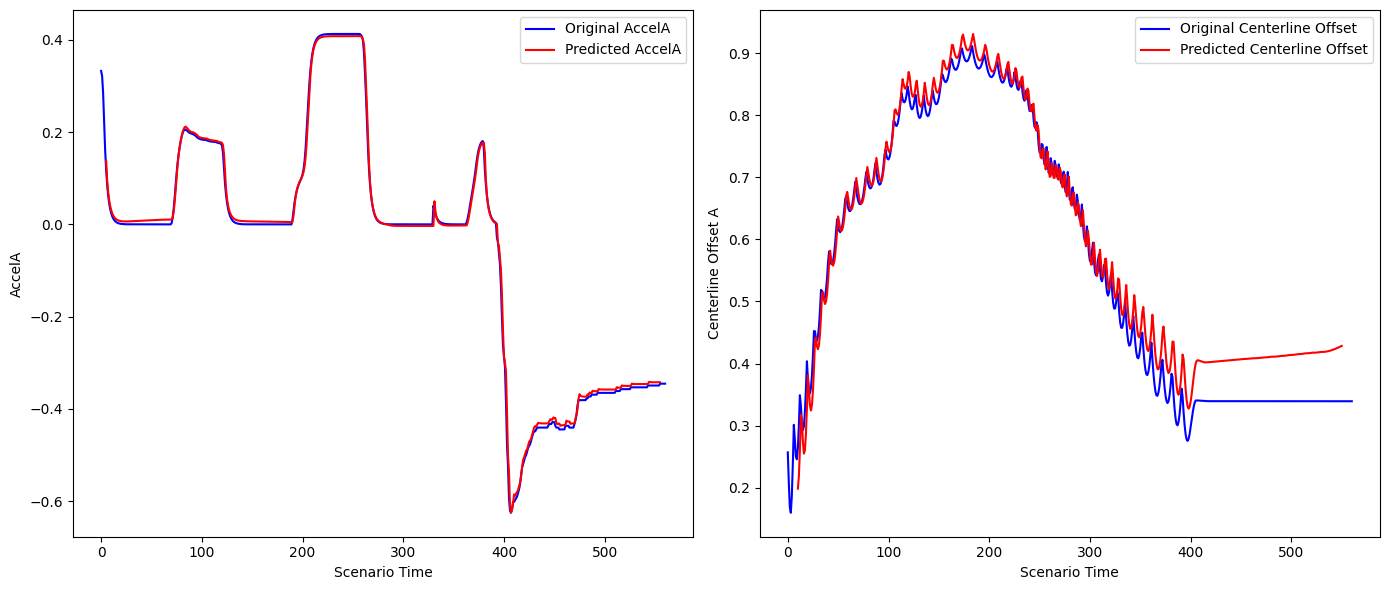

./GeneratedData/CP1_NYC7.feather
AccelA Test MSE: 0.000537584821839551
Centerline_Offset_A Test MSE: 5.949295732813332e-05


In [67]:
print("----- WORST-----")
DrawPicture(list(OutDict.keys())[0], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[1], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[2], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[3], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[4], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
print("----- BEST-----")
DrawPicture(list(OutDict.keys())[-1], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[-2], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[-3], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[-4], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[-5], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)

### Grid Search

In [ ]:
def grid_search_poly_regression(train_data, test_data, feature_list, target_col, degrees, max_lags):
    results = []
    for degree, max_lag in product(degrees, max_lags):
        # Train the model
        model, poly, y_train_pred, y_train, train_mse = train_poly_regression(train_data, feature_list, target_col, degree, max_lag)
        
        # Evaluate the model
        y_test_pred, y_test, test_mse = test_poly_regression(test_data, feature_list, target_col, model, poly, scaler, max_lag)
        
        # Collect results
        results.append({
            'degree': degree,
            'max_lag': max_lag,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'model': model,
            'poly': poly
        })
        print(f"Degree: {degree}, Max Lag: {max_lag}, Train MSE: {train_mse}, Test MSE: {test_mse}")

    # Find best model based on test MSE
    best_result = min(results, key=lambda x: x['test_mse'])
    return best_result, results

In [ ]:
# Parameters to search
degrees = [2]
max_lags = [9, 10, 11, 12, 13, 14]

In [ ]:
# Grid search for AccelA
print("Starting grid search for AccelA...")
best_result_AccelA, results_AccelA = grid_search_poly_regression(train_data, test_data, InputHeader, 'AccelA', degrees, max_lags)
print(f"Best configuration for AccelA: Degree {best_result_AccelA['degree']}, Max Lag {best_result_AccelA['max_lag']} with Test MSE {best_result_AccelA['test_mse']}")

Starting grid search for AccelA...
Degree: 2, Max Lag: 9, Train MSE: 0.014418549682223879, Test MSE: 0.0004644676850309737
Degree: 2, Max Lag: 10, Train MSE: 0.014412053758796757, Test MSE: 0.0004628571546762608
Degree: 2, Max Lag: 11, Train MSE: 0.01440777009616498, Test MSE: 0.00046480279685043703
Degree: 2, Max Lag: 12, Train MSE: 0.014403595364936364, Test MSE: 0.00046732784185182514
Degree: 2, Max Lag: 13, Train MSE: 0.014397073983612315, Test MSE: 0.00046776261323696645
Degree: 2, Max Lag: 14, Train MSE: 0.014391188714366666, Test MSE: 0.0004672275840651991
Best configuration for AccelA: Degree 2, Max Lag 10 with Test MSE 0.0004628571546762608


In [ ]:
# Grid search for Centerline_Offset_A
print("Starting grid search for Centerline_Offset_A...")
best_result_Centerline, results_Centerline = grid_search_poly_regression(train_data, test_data, InputHeader, 'Centerline_Offset_A', degrees, max_lags)
print(f"Best configuration for Centerline_Offset_A: Degree {best_result_Centerline['degree']}, Max Lag {best_result_Centerline['max_lag']} with Test MSE {best_result_Centerline['test_mse']}")

Starting grid search for Centerline_Offset_A...
Degree: 2, Max Lag: 9, Train MSE: 0.006379542705503266, Test MSE: 0.007177057691621126
Degree: 2, Max Lag: 10, Train MSE: 0.006378572135651107, Test MSE: 0.007176312071804878
Degree: 2, Max Lag: 11, Train MSE: 0.0063775710907779766, Test MSE: 0.00717605469968966
Degree: 2, Max Lag: 12, Train MSE: 0.006376728277481425, Test MSE: 0.007176842970139618
Degree: 2, Max Lag: 13, Train MSE: 0.006376012245790589, Test MSE: 0.007209099257788584
Degree: 2, Max Lag: 14, Train MSE: 0.006375266658401583, Test MSE: 0.00721575819716601
Best configuration for Centerline_Offset_A: Degree 2, Max Lag 11 with Test MSE 0.00717605469968966
